# Conditional Workflow with LangGraph and LLM

This notebook demonstrates how to build a **conditional workflow** using **LangGraph** and an **LLM (OpenAI GPT)** for customer support automation.  
Instead of a single response path, the workflow uses **conditional branching**: the system decides dynamically which response node to use based on the type of customer query.

---

## 🔹 Workflow Overview
1. **User Query Input**  
   - A customer query (e.g., *"Why was I charged an extra amount this month?"*) is provided to the workflow.

2. **Classification Step (`classify_query`)**  
   - An LLM classifies the query into one of three categories:  
     - `billing_issue`  
     - `technical_support`  
     - `general_query`

3. **Conditional Branching (`check_category`)**  
   - Based on the predicted category, the workflow routes the query to the corresponding specialized response node:  
     - **Billing Response Node** → Handles billing-related issues.  
     - **Technical Support Response Node** → Handles troubleshooting requests.  
     - **General Response Node** → Handles general inquiries.  

4. **Response Generation**  
   - Each branch uses the LLM with a tailored prompt to generate a polite, context-specific response for the customer.  

5. **End of Workflow**  
   - The workflow returns the predicted category and the generated response.  

---

In [4]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
import os

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "sk-proj-xxxxxxxxxxxxx"

In [7]:
# Step 1: Define the state
class SupportState(TypedDict):
    query: str
    category: str
    response: str

In [6]:
# Step 2: LLM instance (shared)
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.3)

In [8]:
# Step 3: Classification node
def classify_query(state: SupportState):
    user_query = state["query"]
    prompt = f"""
You are a customer service assistant. Classify the following query into one of these categories:
- billing_issue
- technical_support
- general_query

Query: "{user_query}"

Only return one category name.
"""
    result = llm.invoke(prompt)
    return {"category": result.content.strip()}

In [9]:
# Step 4: Billing Response node (uses LLM)
def billing_response(state: SupportState):
    prompt = f"""
You are a billing support agent. Respond to the following customer query politely and informatively:

Query: "{state['query']}"
"""
    result = llm.invoke(prompt)
    return {"response": result.content.strip()}


In [10]:
# Step 5: Technical Support Response node (uses LLM)
def tech_response(state: SupportState):
    prompt = f"""
You are a technical support agent. Troubleshoot and respond to the following customer issue:

Query: "{state['query']}"
"""
    result = llm.invoke(prompt)
    return {"response": result.content.strip()}

In [11]:
# Step 6: General Query Response node (uses LLM)
def general_response(state: SupportState):
    prompt = f"""
You are a general support agent. Provide a helpful and polite response to the following customer question:

Query: "{state['query']}"
"""
    result = llm.invoke(prompt)
    return {"response": result.content.strip()}

In [12]:
# Step 7: Conditional logic
def check_category(state: SupportState) -> Literal["billing_response", "tech_response", "general_response"]:
    cat = state["category"]
    if cat == "billing_issue":
        return "billing_response"
    elif cat == "technical_support":
        return "tech_response"
    else:
        return "general_response"

In [13]:
# Step 8: Build the workflow graph
graph = StateGraph(SupportState)

graph.add_node("classify_query", classify_query)
graph.add_node("billing_response", billing_response)
graph.add_node("tech_response", tech_response)
graph.add_node("general_response", general_response)

graph.add_edge(START, "classify_query")
graph.add_conditional_edges("classify_query", check_category)
graph.add_edge("billing_response", END)
graph.add_edge("tech_response", END)
graph.add_edge("general_response", END)

workflow = graph.compile()

In [14]:
input_data = {
    "query": "Why was I charged an extra amount this month?"
}

In [15]:
final_state = workflow.invoke(input_data)

In [16]:
print("Category:", final_state["category"])

Category: billing_issue


In [17]:
print("Response:", final_state["response"])

Response: Dear customer,

Thank you for reaching out to us regarding the extra charge on your bill this month. I understand your concern and I would be happy to assist you with this matter.

In order to provide you with more specific information about the extra charge, could you please provide me with your account details such as your account number or phone number associated with the account? This will help me to review your billing statement and identify the reason for the additional amount.

Once I have this information, I will be able to investigate the issue further and provide you with a detailed explanation of the extra charge on your bill. Thank you for your cooperation and I look forward to resolving this matter for you.

Best regards,
[Your Name]
Billing Support Agent


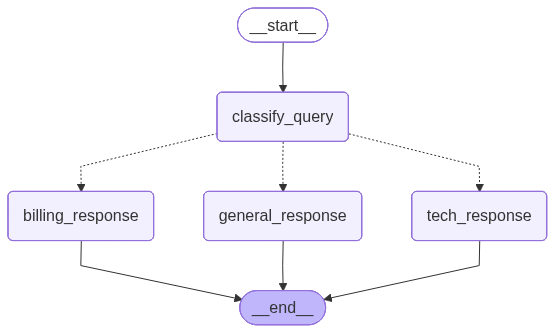

In [18]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())